In [36]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


In [40]:
# Global Constants
GENERATIONS = 100
ROWS = COLS = GENERATIONS + 50
ORIGIN = (COLS // 2, ROWS // 2)
PHI = ROWS * COLS
CANCER_INIT_POSITIONS = [(ORIGIN[0], ORIGIN[1]), (ORIGIN[0] + 1, ORIGIN[1]), 
                         (ORIGIN[0] - 1, ORIGIN[1]), (ORIGIN[0], ORIGIN[1] - 1), 
                         (ORIGIN[0], ORIGIN[1] + 1)]

K1, K2, K3, K4 = 0.7, 0.2, 0.3, 0.3
RHO = 3.85

In [22]:
def initialize_grid():
    M = np.full((ROWS, COLS), 'N')
    for pos in CANCER_INIT_POSITIONS:
        M[pos] = 'C'
    return M

def sum_cell_type(M, cell_type):
    """ Count number of a specific type of cell in the grid. """
    return np.sum(M == cell_type)

def mitosis_probability(k, n, p):
    """ Calculate probability of cell mitosis. """
    return k * (1 - n / p)

def origin_distance(r, c):
    """ Calculate grid distance from origin. """
    return math.sqrt((r - ORIGIN[0])**2 + (c - ORIGIN[1])**2)

def density_development(M):
    """ Calculate density development of tumor. """
    c = sum_cell_type(M, 'C')
    e = sum_cell_type(M, 'E')
    d = sum_cell_type(M, 'D')
    n_prime = c + e + d
    R = 0
    for i in range(ROWS):
        for j in range(COLS):
            if M[i, j] == 'C':
                R += origin_distance(i, j)
    R = R / n_prime if n_prime else 0
    return n_prime / R**2 if R else 0

def get_quadrant(r, c):
    """ Get quadrant of coordinates relative to origin. """
    if r <= ORIGIN[0] and c > ORIGIN[1]:
        return 'I'
    elif r <= ORIGIN[0] and c <= ORIGIN[1]:
        return 'II'
    elif r > ORIGIN[0] and c <= ORIGIN[1]:
        return 'III'
    else:
        return 'IV'

def mitosis(M, newM, r, c, dense):
    """ Model cell division with density development. """
    up, rt, dn, lt = (r-1, c), (r, c+1), (r+1, c), (r, c-1)
    quadrant = get_quadrant(r, c)
    dense_map = {'I': [up, rt], 'II': [lt, up], 'III': [dn, lt], 'IV': [rt, dn]}
    not_dense_map = {'I': [dn, lt], 'II': [rt, dn], 'III': [up, rt], 'IV': [lt, up]} 
    not_normal = ('E', 'D')
    map_choice = dense_map if dense else not_dense_map
    choices = map_choice[quadrant]
    
    for choice in choices:
        if newM[choice] not in not_normal:
            newM[choice] = 'C'
            break

def simulate_tumor_growth_one_step(M):
    newM = np.copy(M)
    dense = density_development(M) > RHO
    for r in range(1, ROWS):
        for c in range(1, COLS):
            if M[r, c] == 'C':
                if random.random() < mitosis_probability(K1, sum_cell_type(M, 'C'), PHI):
                    mitosis(M, newM, r, c, dense)
                elif random.random() < K2:
                    newM[r, c] = 'E'
            elif M[r, c] == 'E' and random.random() < K3:
                newM[r, c] = 'D'
            elif M[r, c] == 'D' and random.random() < K4:
                newM[r, c] = 'N'

    return newM

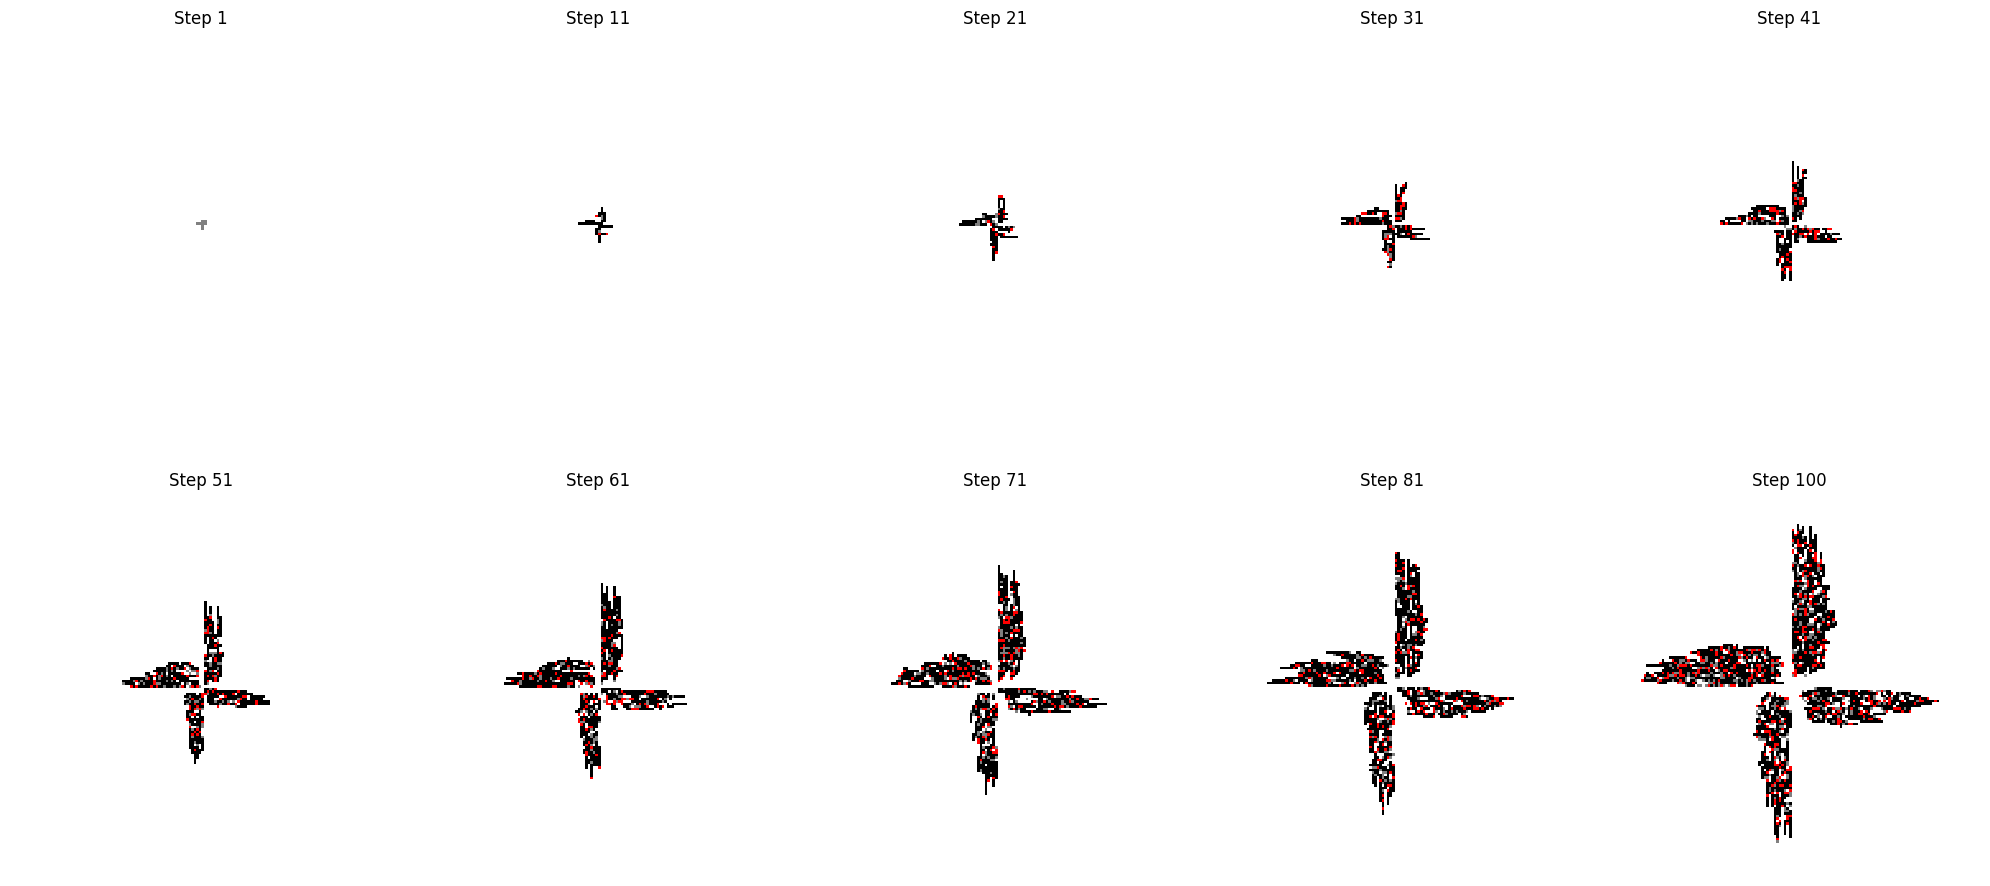

In [45]:
M = initialize_grid()

cmap = ListedColormap(['white', 'black', 'red', 'gray'])

save_every_n_generations = 10
num_plots = GENERATIONS // save_every_n_generations
plots_per_row = min(5, num_plots)  # Maximum of 3 plots per row
num_rows = (num_plots + 2) // plots_per_row  # Calculate number of rows needed

fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(20, num_rows * 5))  # Adjust figsize as needed

cell_to_int = {'N': 0, 'C': 1, 'E': 2, 'D': 3}

# Run the simulation for each generation
for g in range(GENERATIONS):
    M = simulate_tumor_growth_one_step(M)
    if g % save_every_n_generations == 0 or g == GENERATIONS - 1:
        # Convert the current state to integers for plotting
        int_grid = np.vectorize(cell_to_int.get)(M)
        
        # Determine which subplot to use
        plot_row = (g // save_every_n_generations) // plots_per_row
        plot_col = (g // save_every_n_generations) % plots_per_row
        ax = axes[plot_row, plot_col] if num_plots > 1 else axes
        
        # Plot the current state
        ax.imshow(int_grid, cmap=cmap, interpolation='nearest')
        ax.set_title(f'Step {g + 1}')
        ax.axis('off')  # Hide the axis

plt.tight_layout()
plt.show()
